In [14]:
# ! pip install numpy >> /dev/null
# ! pip install pandas >> /dev/null
# ! pip install opencv-python >> /dev/null
# ! pip install scipy >> /dev/null
# ! pip install torch >> /dev/null
# ! pip install matplotlib >> /dev/null
# ! pip install git+https://github.com/NVlabs/nvdiffrast >> /dev/null

# %pip install pyyaml

In [15]:
import torch
assert torch.cuda.is_available()


import os
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm

##### Download camera paramethers

In [16]:
import yaml

CAMERA = 1
downloaded_params = None

with open("camchain-calibration-equidistant4_camimu_dataset-calib-imu1.yaml") as stream:
    try:
        downloaded_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        raise Exception("Hello!")


In [17]:
INPUT_DIR = "./dataset-seq1/mav0/" # replace with your sequence
ORIGINAL_VIDEONAME = "output_orig.mp4"
UNDISTORTED_VIDEONAME = "output_undist.mp4"
RS_REMOVED_VIDEONAME = "output_nors.mp4"
STABILIZED_VIDEONAME = "output_stable_nors.mp4"


# camera params
FPS = 20

# camera intrinsics
pin_hole_model = downloaded_params[f"cam{CAMERA}"]["intrinsics"]
K = np.array([[pin_hole_model[0], 0, pin_hole_model[2]], 
              [0, pin_hole_model[1], pin_hole_model[3]],
              [0, 0, 1]])

# output camera intrinsics
K_new = K.copy()

# distortion params
D = np.array(downloaded_params[f"cam{CAMERA}"]["distortion_coeffs"])

# rotation from imu-to-camera
R_cam_imu = np.array(downloaded_params[f"cam{CAMERA}"]["T_cam_imu"])

# time delta between 2 sensor rows sensing 
dt_rs = 29.47 * 10 ** -6 # in seconds

# frame dimensions
W, H = 1280, 1024



In [18]:
def frames_to_video(frames, output_video, fps=20, isColor=False):
    """
    Create a video from a list of frames.

    :param frames: list of frames
    :param output_video: output video file name (e.g., 'output.mp4')
    :param fps: frames per second (default=20)
    """
    if len(frames) == 0:
        raise ValueError("No frames provided")

    # Use the first frame to get dimensions
    height, width, *channels = frames[0].shape

    # Define video writer (using mp4v codec)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=isColor)

    for frame in tqdm(frames, desc="Writing frames to video: "):
        video.write(frame)
        

frames_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "cam1/data/*.png")))
print(f"Number of frames in the video: {len(frames_paths)}")

frames = [cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) for frame_path in frames_paths]
# frames_to_video(frames, ORIGINAL_VIDEONAME, FPS)

Number of frames in the video: 808


### Homework 2

Given input video from camera with rolling shutter, implement and apply the following algorithms:

    - radial distortion correction (use cv2.fisheye module)
    - rolling shutter correction
    - video stabilization

Expected output of the homework:

    - Jupyter notebook with working code that we can run in real-time
    - plots of camera orientations in time for unstabilized and stabilized motion [plot individual x/y/z components in axis-angle representation]
    - plots of input/output meshgrids for the video frame, where angular velocity has the biggest norm
    - 4 videos stacked together with their frames side-by-side:
        - original
        - undistorted 
        - undistorted + rolling shutter corrected
        - undistorted + rolling shutter corrected + stabilized

Note:
Dataset used in homework provides two sources of camera orientations: IMU (Gyro) measurements of angular velocity and Motion Capture direct measurements of orientation. You should use IMU (Gyro) measurements and implement angular velocity integration. You can use Motion Capture direct measurements of orientation to verify that your integration is implemented correctly.

Rolling shutter correction algorithm is based on this paper: [Digital Video Stabilization and Rolling Shutter Correction using Gyroscopes](https://graphics.stanford.edu/papers/stabilization/).

Dataset: [Rolling-Shutter Visual-Inertial Odometry Dataset](https://cvg.cit.tum.de/data/datasets/rolling-shutter-dataset)

Calibrated camera params can be found [here](https://cdn3.vision.in.tum.de/rolling/calibration/camchain-calibration-equidistant4_camimu_dataset-calib-imu1.yaml)

![Camera Set-up](https://cvg.cit.tum.de/_media/data/datasets/rolling-shutter-dataset/sensor_axes_rgb.jpg?w=800&tok=fa3d4a)

In [19]:
def cv2_imshow(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

### Undistort the video using **cv2 fisheye module**

In [20]:
def undistort_frame(frame, K, D, W, H):
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (W, H), cv2.CV_16SC2)
    undistorted_img = cv2.remap(frame, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img


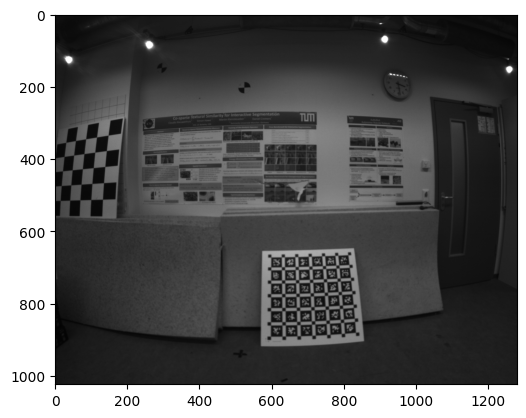

In [21]:
cv2_imshow(frames[0])

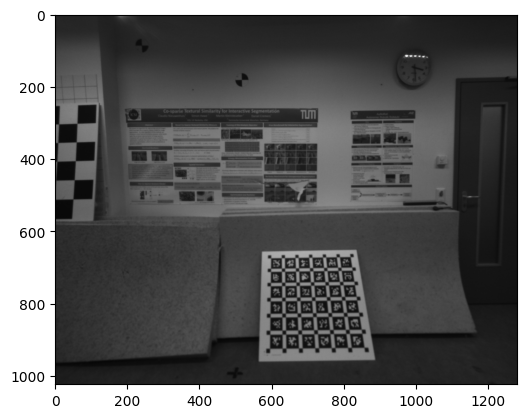

In [22]:
cv2_imshow(undistort_frame(frames[0], K, D, W, H))